<a href="https://www.kaggle.com/code/fiftythirtyfour/on-time-performance-usa-2023?scriptVersionId=237127170" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  📥 Load

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/2023-us-civil-flights-delay-meteo-and-aircraft/US_flights_2023.csv')

In [3]:
df.columns = df.columns.str.lower()
num = df.select_dtypes(include='number').columns.to_list()
cat = df.select_dtypes(include='object').columns.to_list()
df['dep_otp_15'] = np.where(df['dep_delay'] <= 15, 1, 0)
target = 'dep_otp_15'
num.remove('dep_delay_tag')

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2)

# 🤓 Data Science


In [4]:
df[num].corrwith(df[target]).sort_values(ascending=False)

aicraft_age          -0.007045
day_of_week          -0.027177
delay_security       -0.035377
flight_duration      -0.041338
delay_weather        -0.101854
delay_nas            -0.184385
delay_carrier        -0.272477
delay_lastaircraft   -0.370870
arr_delay            -0.522125
dep_delay            -0.534136
dtype: float64

In [5]:
df[target].mean()

0.8022264423131107

# 🤖 Machine

In [6]:
num

['day_of_week',
 'dep_delay',
 'arr_delay',
 'flight_duration',
 'delay_carrier',
 'delay_weather',
 'delay_nas',
 'delay_security',
 'delay_lastaircraft',
 'aicraft_age']

In [7]:
cat

['flightdate',
 'airline',
 'tail_number',
 'dep_airport',
 'dep_cityname',
 'deptime_label',
 'dep_delay_type',
 'arr_airport',
 'arr_cityname',
 'arr_delay_type',
 'distance_type',
 'manufacturer',
 'model']

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

dly = [x for x in df.columns if x.startswith('delay_')]
pipe = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), dly)
    , (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['airline'])
)

pipe.fit(train)
train_pre = pipe.transform(train)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [10]:
log = LogisticRegression(max_iter=1000)
log.fit(train_pre, train[target])
cross_val_score(log, train_pre, train[target], scoring='accuracy').mean()

0.9465177359576267

In [11]:
gnb = GaussianNB()
gnb.fit(train_pre, train[target])
cross_val_score(gnb, train_pre, train[target], scoring='accuracy').mean()

0.9439146365972798

In [12]:
model = log

# 🦾 Residuals

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mod = make_pipeline(pipe, model)

In [14]:
preds = mod.predict(test)
print(accuracy_score(test[target], preds))
print(classification_report(test[target], preds))


0.9468050636140051
              precision    recall  f1-score   support

           0       0.94      0.78      0.85    266406
           1       0.95      0.99      0.97   1082275

    accuracy                           0.95   1348681
   macro avg       0.94      0.88      0.91   1348681
weighted avg       0.95      0.95      0.94   1348681



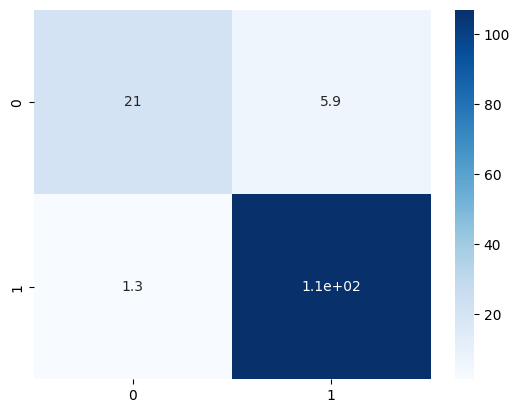

In [15]:
sns.heatmap(confusion_matrix(test[target], preds)/10000, annot=True, cmap='Blues');